# Customer Segementation

## Introduction

In this notebook we'll do some customer segmentation work. Segmentation can help you to identify and understand customer subgroups and how they differ from one another. Customer segmentation has many beneficial uses. In our case for example, it can be used to assign the best-fit agent, identify opportunities for leveraging agent skills, or even to create hosting opportunities to improve client engagement.<br><br>
We'll prepare the data so its in a wide format ready for segmentation and then apply some transformation and clustering techniques. Our data contains demographic, summary product, and communication information. Since there are currently no predefined segments we'll need to discover segments within the underlying data structure. Once that structure is found we'll assign clients to their respective clusters and surface that information through and user interface.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
import sys

if '../scripts' not in sys.path:
    sys.path.insert(0, '../scripts')
    
from customer_segmentation_prep import *

%matplotlib inline

## Plot Distributions

Here is a plotting function with an example to view the dustribution of any feature within the dataset

In [2]:
# Plot function for feature distribution
def plot_chart(df, col_name, col_type=None):
    
    if col_type == None:
        if is_string_dtype(df[col_name]):
            col_type = 'string'
        elif is_numeric_dtype(df[col_name]):
            col_type = 'numeric'
        else:
            print('Pass col_type to function to specify if it is string or numeric')
        
    if col_type == 'string':
        ax = df[col_name].value_counts().plot(kind='bar')
        ax.set_ylabel('Count')
    elif col_type == 'numeric':
        # if there are less than 10 values in the numeric column we redefine it as a string so we plot a bar chart
        if df[col_name].nunique() <= 10:
            ax = df[col_name].value_counts().sort_index().plot(kind='bar')
        else:
            ax = df[col_name].plot.density()
            
        ax.get_xaxis().set_major_formatter(
            plt.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    else:
        print(' Re-run specifying the col_type')

    ax.set_xlabel(col_name)
    ax.set_title(col_name + ' Column Distribution')

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)


## User Inputs and Data Prep

### User Inputs
**effective_date :**  This is the date that the segmentation is computed. All input data should be before this date.<br>
**train_or_score :**  Specify whether we are prepping the data for training or scoring. Should alway be 'train' in this notebook.<br>

**granularity_key :** Specifies the customer ID column.<br>
**customer_start_date :** Column with the start of the summary month of cusotmer data.<br> 
**customer_end_date :** As above, but last day of the summary month.<br>
**status_attribute :** Column which indicates whether the customer is active or inactive and is used to define churn. Churned customers are removed from the dataset.<br>
**status_flag_active :** The name of the variable in the status_attribute that indicates that the customer has churned, in this case it is 'Inactive'.<br>
**date_customer_joined :** Specifies the column where the customer join date is recorded. This variable is used to calculate customer tenure.<br>

**columns_required :** A list of default columns required, includes ID column and date columns.<br>
**default_attributes :** A list of the variables that we would like to use for the segmentation.<br>
**risk_tolerance_list :** A list of the risk categories for the customer's accounts. 'High', 'Low' etc.<br> 
**investment_objective_list :** A list of the investment objective categories for the customer's accounts. 'Security', 'Income' etc.<br>

The last three user input variables are used for data cleaning.<br>
**std_multiplier :** This variable is used to identify outlier values. This number is multiplied by the variable standard deviation. Any value above this is defined as an outlier and the value is capped at this number multiplied by the standard deviation.<br>
**max_num_cat_cardinality :** This variable defines the maximum cardinality for categorical variables. Any categorical variable with more categories than this maximum is removed from the dataset.<br> 
**nulls_threshold :** This threshold is used to identify columns with many null values. Any column with percentage of nulls greater than this threshold will be removed from the dataset.<br>

The user can use the default inputs as listed below or can choose their own. The user inputs will be stored and the same inputs will be applied automatically at scoring time. 


### Data Prep
See scripts/customer_segmentation_prep.py for details of data preparation.

The script generates the dataset that is used for clustering. We take a wide form dataset with customer details, filter to include only columns that are relevant, complete data cleaning and produce a dataframe suitable for clustering. 

### Data Cleaning
•	Any customer who churned in the dataset is removed. Only active customers are used for clustering.<br>
•	We take the most recent record for each customer.<br>
•	Any columns in the dataset that have a single constant value are removed.<br>
•	Any column with more than 10% null values is removed.<br>
•	High cardinality categorical columns are removed.<br>
•	Numerical outliers are cleaned. <br>
•	Remaining missing values are filled with 'Unknown' for categorical and the average of the column for numerical. 

In [3]:
# User input variables
effective_date = '2018-09-30'  # date at which the prediction was computed 
train_or_score = 'train'

granularity_key='CUSTOMER_CUSTOMER_ID'
customer_start_date='CUSTOMER_SUMMARY_START_DATE'
customer_end_date='CUSTOMER_SUMMARY_END_DATE'
status_attribute='CUSTOMER_STATUS'
status_flag_active='Active'
date_customer_joined='CUSTOMER_RELATIONSHIP_START_DATE'

columns_required=['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_STATUS', 'CUSTOMER_SUMMARY_START_DATE', 'CUSTOMER_SUMMARY_END_DATE',
                    'CUSTOMER_EFFECTIVE_DATE',  'CUSTOMER_SYSTEM_LOAD_TIMESTAMP']

default_attributes=['CUSTOMER_GENDER', 'CUSTOMER_AGE_RANGE', 'CUSTOMER_EDUCATION_LEVEL',
                            'CUSTOMER_EMPLOYMENT_STATUS', 'CUSTOMER_MARITAL_STATUS', 'CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN',
                            'CUSTOMER_URBAN_CODE', 'CUSTOMER_ANNUAL_INCOME', 'CUSTOMER_RELATIONSHIP_START_DATE',
                            'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_SUMMARY_RETURN_SINCE_INCEPTION',
                            'CUSTOMER_SUMMARY_RETURN_LAST_QUARTER', 'CUSTOMER_SUMMARY_ASSETS',
                            'CUSTOMER_SUMMARY_NUMBER_OF_ACTIVE_ACCOUNTS', 'CUSTOMER_SUMMARY_NUMBER_OF_EMAILS',
                            'CUSTOMER_SUMMARY_NUMBER_OF_LOGINS', 'CUSTOMER_SUMMARY_NUMBER_OF_CALLS',
                            'CUSTOMER_SUMMARY_TOTAL_NUMBER_OF_BUY_TRADES', 'CUSTOMER_SUMMARY_TOTAL_NUMBER_OF_SELL_TRADES',
                            'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_ALL_FEES']
risk_tolerance_list = []
investment_objective_list = []

std_multiplier=5
max_num_cat_cardinality=10
nulls_threshold=0.1

In [4]:
df_raw = pd.read_csv('../datasets/customer_full_summary_latest.csv',
                     parse_dates=['CUSTOMER_RELATIONSHIP_START_DATE',
                                 'CUSTOMER_SUMMARY_END_DATE', 'CUSTOMER_SUMMARY_START_DATE'], infer_datetime_format=True)

data_prep = CustomerSegmentationPrep(train_or_score=train_or_score, effective_date=effective_date, granularity_key=granularity_key, customer_start_date=customer_start_date, customer_end_date=customer_end_date,
                                        status_attribute=status_attribute, status_flag_active=status_flag_active, date_customer_joined=date_customer_joined, columns_required=columns_required, default_attributes=default_attributes,
                                        risk_tolerance_list=risk_tolerance_list, investment_objective_list=investment_objective_list, std_multiplier=std_multiplier, max_num_cat_cardinality=max_num_cat_cardinality, nulls_threshold=nulls_threshold)
df_prepped = data_prep.prep_data(df_raw, train_or_score)

Before removing inactive customers we have 1000 customers
After removing inactive customers we have 838 customers
Before cleaning, we had 24 columns.
After cleaning, we have 19 columns.
Add a column for customer tenure
Prepped data has 838 rows and 17 columns.
Prep has data for 838 customers


In [5]:
# Preview prepped data
df_prepped.head()

,CUSTOMER_CUSTOMER_ID,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_ALL_FEES,CUSTOMER_AGE_RANGE,CUSTOMER_URBAN_CODE,CUSTOMER_EDUCATION_LEVEL,CUSTOMER_SUMMARY_NUMBER_OF_ACTIVE_ACCOUNTS,CUSTOMER_EFFECTIVE_DATE,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT,CUSTOMER_GENDER,CUSTOMER_MARITAL_STATUS,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,CUSTOMER_EMPLOYMENT_STATUS,CUSTOMER_SUMMARY_TOTAL_NUMBER_OF_BUY_TRADES,CUSTOMER_ANNUAL_INCOME,CUSTOMER_SUMMARY_ASSETS,CUSTOMER_SUMMARY_TOTAL_NUMBER_OF_SELL_TRADES,CUSTOMER_TENURE_IN_MONTHS
0,1000,12.949927,30 to 40,City,College,2,2018-01-02,100000.0,Male,Married,1,Employed,1,88936.0,120823.0,0,8
1,1001,1105.796668,65 and over,Urban,Professional,4,2017-11-29,1250000.0,Female,Divorced,0,Selfemployed,1,144189.0,253441.0,0,10
2,1002,238.521975,55 to 65,Urban,PhD,2,2017-08-28,80000.0,Female,Married,0,Homemaker,1,127032.0,203284.0,0,13
3,1003,267.939520,65 and over,Urban,PhD,3,2018-01-17,80000.0,Female,Married,0,Homemaker,1,118908.0,194884.0,1,8
4,1004,129.675826,40 to 55,City,College,2,2018-01-03,1250000.0,Male,Married,2,Employed,1,83259.0,123576.0,0,8


Now that the data is prepared we need to continue with a few more data preparation steps before we can do clustering. First is to simply remove the columns `CUSTOMER_CUSTOMER_ID` and `CUSTOMER_EFFECTIVE_DATE` since they're not needed for segmentation.

In [6]:
# Drop columns not needed for segmentation
df_prepped.drop(['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_EFFECTIVE_DATE'], axis=1, inplace=True)

### Dummy Variables

Next, since our data contains mixed data types, categorical and numeric, we need to convert those categorical features to numeric by creating binary dummy variables. Once we create the dummy variables from the categorical features we'll drop the original cvategorical features.

In [7]:
# Create lists of the numeric and categorical features
numeric_cols = list(df_prepped.select_dtypes(include=[np.number]).columns)
categorical_cols = list(df_prepped.select_dtypes(include=[object]).columns)

# Copy of the prepped dataframe before any transformations are carried out
prepped_data_pre_transform = df_prepped.copy()

# Create dummy variables for categorical features and drop original
for col in categorical_cols:
    df_prepped = pd.concat([df_prepped, pd.get_dummies(df_prepped[col], prefix=col, drop_first=True)], axis=1)
    df_prepped.drop(col, axis=1, inplace=True)

### Normalize Data

The last step for our data preparation is to normalize the numeric variables. Normalizing numeric values prior to clustering is common practice especially when dealing with features of varying scales (number of children vs summary of assets amount). This helps to improve the cluster quality as well as cluster algorithm accuracy and performance.

In [8]:
# Calculate mean and standard deviation for normalization
numeric_cols_to_exclude_from_clustering = []
dict_col_means = {}
dict_col_stds = {}
for col in numeric_cols:
    col_mean = df_prepped[col].mean()
    col_std = df_prepped[col].std()
    dict_col_means[col] = col_mean
    dict_col_stds[col] = col_std
    numeric_cols_to_exclude_from_clustering.append(col)
    
    df_prepped[col + '_standardised'] = (df_prepped[col] - col_mean)/col_std

# Store original numeric columns and drop from clustering data set
df_orig_numeric_cols = df_prepped[numeric_cols_to_exclude_from_clustering].copy()
df_prepped.drop(numeric_cols_to_exclude_from_clustering, axis=1, inplace=True)

In [9]:
# Preview prepped data with normalized numeric values
df_prepped.head()

,CUSTOMER_AGE_RANGE_30 to 40,CUSTOMER_AGE_RANGE_40 to 55,CUSTOMER_AGE_RANGE_55 to 65,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_URBAN_CODE_Rural,CUSTOMER_URBAN_CODE_Urban,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University,...,CUSTOMER_EMPLOYMENT_STATUS_Unemployed,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_ALL_FEES_standardised,CUSTOMER_SUMMARY_NUMBER_OF_ACTIVE_ACCOUNTS_standardised,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_standardised,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN_standardised,CUSTOMER_SUMMARY_TOTAL_NUMBER_OF_BUY_TRADES_standardised,CUSTOMER_ANNUAL_INCOME_standardised,CUSTOMER_SUMMARY_ASSETS_standardised,CUSTOMER_SUMMARY_TOTAL_NUMBER_OF_SELL_TRADES_standardised,CUSTOMER_TENURE_IN_MONTHS_standardised
0,1,0,0,0,0,0,0,0,0,0,...,0,-0.461086,-0.738136,-0.860592,0.024526,0.148071,-0.188227,-0.499506,-0.840165,-0.896993
1,0,0,0,1,0,1,0,0,1,0,...,0,0.038932,1.726239,1.640472,-1.184446,0.148071,1.748195,1.893382,-0.840165,-0.700707
2,0,0,1,0,0,1,0,1,0,0,...,0,-0.357879,-0.738136,-0.904089,-1.184446,0.148071,1.146903,0.988376,-0.840165,-0.406276
3,0,0,0,1,0,1,0,1,0,0,...,0,-0.344419,0.494051,-0.904089,-1.184446,0.148071,0.862185,0.836811,1.188822,-0.896993
4,0,1,0,0,0,0,0,0,0,0,...,0,-0.407680,-0.738136,1.640472,1.233497,0.148071,-0.387186,-0.449833,-0.840165,-0.896993


## Principal Componenets Analysis (PCA)

Now that our data is clean with some transformations we're going to do one last transformation. We'll use principal componenents analysis (PCA) to reduce the dimensionality of our data and reduce clustering computation. Also, performing PCA prior to clustering can often help with performance if there are underlying linear relationships with the data. This isn't always the case and is dependent on your data, but it did hold true with our customer dataset.

Below we perform PCA on our dataset and select 12 compononets. You can see the newly transformed and reduced data set below. This will be the data set that we pass to our clustering algorithm.

In [10]:
# PCA
pca = PCA(n_components=12)
df_pca = pca.fit_transform(df_prepped)

# Preview transformed data
pd.DataFrame(df_pca).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.080145,-0.294567,0.998583,0.240472,-0.557323,0.406732,-0.608915,-0.641405,-0.631579,0.608975,-0.593018,0.349710
1,3.517837,0.468669,-0.190887,0.573117,-0.928437,-0.779083,1.376132,-0.878197,-0.832980,0.288401,0.501005,0.179596
2,1.421227,-0.696913,0.835251,-0.205975,-0.492121,1.660835,-0.661461,-0.633952,0.343414,1.047442,0.476421,0.057319
3,1.543963,0.667743,-0.051702,-1.376609,0.481265,0.740521,-0.647986,-1.209993,0.022787,0.448835,0.166131,-0.185272
4,-0.973515,-0.096375,0.324135,2.204278,-0.333090,-1.075265,-0.043192,-0.575593,0.416361,-0.251479,-0.345426,-0.328097


From our PCA, we can view how much variance is explained for each additional principal component. The below cumulative sum shows that the first 12 components explains 95.6% of the data.

In [11]:
# Percent variance explained array
print(np.cumsum(pca.explained_variance_ratio_))

[0.28503983 0.41520115 0.5265373  0.61311007 0.69069651 0.76400721
 0.8275371  0.87381037 0.9046829  0.92626395 0.94228909 0.95627331]


Below we save our PCA model for later scoring.

In [12]:
# Save out PCA
from sklearn.externals import joblib
joblib.dump(pca, '../datasets/pca.joblib')

['../datasets/pca.joblib']

## K-means Clustering

We can now begin clustering. For clustering we'll use the k-means clustering algorithm. K-means clustering simply partitions the data into k clusters where each observation or client belongs to the cluster with the nearest mean. When using k-means you have to specify the number of clusters beforehand, but often times that number is unknown. We'll loop through the k-means algorithm using a range of number of clusters and determine cluster number by using the metric called silhouette coefficient. The silhouette coefficient indicates how similar the observations within its own cluster are compared to other observations in different clusters. Range for silhouette coefficient are from -1 to 1 where 1 represents objects within its own clsuter are well paired.

In [13]:
# Specify max number of clusters for iteration
max_number_of_clusters = 15

# Loop through K-means and view silhouette coefficient to determine number of clusters
for i in range(2, max_number_of_clusters+1):
    kmeans_mdl = KMeans(n_clusters=i, random_state=1234)
    kmeans_mdl.fit(df_pca)
    labels = kmeans_mdl.labels_
    silhouette_coef = metrics.silhouette_score(df_pca, labels, metric='euclidean')
    print('Silhouette coefficient for ' + str(i) + ' clusters:' + str(silhouette_coef))

Silhouette coefficient for 2 clusters:0.2606482865444613
Silhouette coefficient for 3 clusters:0.27743217771882533
Silhouette coefficient for 4 clusters:0.22756864736945645
Silhouette coefficient for 5 clusters:0.21627829146338773
Silhouette coefficient for 6 clusters:0.23357307701726637
Silhouette coefficient for 7 clusters:0.22869225906896434
Silhouette coefficient for 8 clusters:0.21141194473468922
Silhouette coefficient for 9 clusters:0.21267853259010258
Silhouette coefficient for 10 clusters:0.20476447415722815
Silhouette coefficient for 11 clusters:0.19600290370051776
Silhouette coefficient for 12 clusters:0.2043225595173196
Silhouette coefficient for 13 clusters:0.20494912818238975
Silhouette coefficient for 14 clusters:0.2077131837953413
Silhouette coefficient for 15 clusters:0.2011470641582582


For the above exercise we see that number of clusters should be around 6 or 7 based on the silhouette coefficient. For this exercise, 7 clusters were selected due to better visualization below but either cluster number would be acceptable.

We then fit the k-means algorithm to our data using the specified 7 clusters. Then we add those cluster assignments back to the PCA dataframe so we can visualize the cluster assignments on a 2-dimensional plot.

In [14]:
# K-means with 7 clusters based on silhouette coefficient
kmeans_mdl = KMeans(n_clusters=7, random_state=1234)
pc_clusters = kmeans_mdl.fit_predict(df_pca)

In [15]:
# Create dataframe with PCA and cluster assignments
df_pca_clusters = pd.DataFrame(df_pca, columns=['pc_1','pc_2','pc_3','pc_4','pc_5','pc_6','pc_7','pc_8','pc_9','pc_10','pc_11','pc_12'])
df_pca_clusters['cluster_id'] = pc_clusters
df_pca_clusters.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,cluster_id
0,-1.080145,-0.294567,0.998583,0.240472,-0.557323,0.406732,-0.608915,-0.641405,-0.631579,0.608975,-0.593018,0.349710,2
1,3.517837,0.468669,-0.190887,0.573117,-0.928437,-0.779083,1.376132,-0.878197,-0.832980,0.288401,0.501005,0.179596,1
2,1.421227,-0.696913,0.835251,-0.205975,-0.492121,1.660835,-0.661461,-0.633952,0.343414,1.047442,0.476421,0.057319,6
3,1.543963,0.667743,-0.051702,-1.376609,0.481265,0.740521,-0.647986,-1.209993,0.022787,0.448835,0.166131,-0.185272,6
4,-0.973515,-0.096375,0.324135,2.204278,-0.333090,-1.075265,-0.043192,-0.575593,0.416361,-0.251479,-0.345426,-0.328097,3


## Visualize Clusters

To se the visual representation of our newly assigned clusters we plot, on a 2-dimensional plot, the 1st principal component with the 2nd principal component as the x and y-axis. Then we set the `cluster_id` as the color so we can better visualize the cluster assignments or segments. You can see from below that we have some nice exclusiveness with our clusters even on the 2-dimensional space.

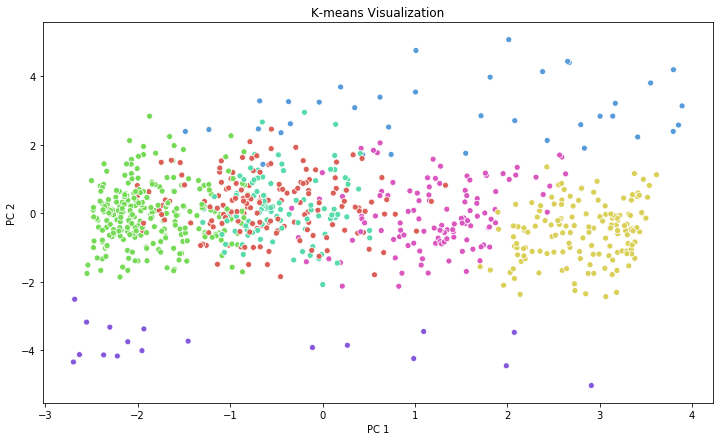

In [16]:
import seaborn as sns

# Plot k-means results with cluster assignments
plt.figure(figsize=(12,7))

ax = sns.scatterplot(
    x="pc_1",
    y="pc_2",
    data=df_pca_clusters,
    hue="cluster_id",
    legend=False,
    palette=sns.color_palette("hls", 7)
)

ax.set(xlabel="PC 1", ylabel="PC 2", title="K-means Visualization");

## Model Deployment

The last step in this notebook is to save out our K-means clsutering model as well as our values that we used to normalize the numeric features. Then we save the cluster statistics to later use in a dashboard when reporting information about segments.

In [ ]:
from dsx_ml.ml import save
import pprint

# Save k-means model out so it can be used for scoring
resp = save( model=kmeans_mdl, 
                 name='KMeans_model', 
                 x_test=df_prepped,  
                 algorithm_type='Classification' )
print("\n{} saved to:\n".format('KMeans_model'))
pprint.pprint(resp)

# Save out the mean and standard deviation of each numeric feature to score new data
with open('../datasets/col_means.json', 'w') as f:
    json.dump(dict_col_means, f)

with open('../datasets/col_stds.json', 'w') as f:
    json.dump(dict_col_stds, f)

Using TensorFlow backend.


In [17]:
# Save values for each numerical variable to be used for scoring and in the dashboard

prepped_data_pre_transform['CLUSTERS'] = kmeans_mdl.labels_
summary_dict = {}

for cluster in range(0, prepped_data_pre_transform['CLUSTERS'].max()+1):
    summary_dict[cluster] = {}
    for col in numeric_cols:
        col_max = prepped_data_pre_transform[prepped_data_pre_transform['CLUSTERS']==cluster][col].max()
        col_min = prepped_data_pre_transform[prepped_data_pre_transform['CLUSTERS']==cluster][col].min()
        summary_dict[cluster][col] = {}
        summary_dict[cluster][col]['min'] = col_min
        summary_dict[cluster][col]['max'] = col_max

# save out data so that it can be used for scoring and dashboard
joblib.dump(summary_dict, '../datasets/numeric_data_ranges.joblib')

['../datasets/numeric_data_ranges.joblib']